## Exploring remotely-stored Zarr datasets using Xarray

Import packages

In [1]:
import os
import s3fs
import boto3
import fsspec
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime

from IPython.display import Image

### View datasets in the object store buckets (using S3FS)

- 'anon=True' means 'access the data as an anonymous user' which is what you want to do when the data is available publically to anyone
- The 'endpoint_url' is essentially the website that is hosting the data

In [2]:
s3 = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': "https://fdri-o.s3-ext.jc.rl.ac.uk"})

Annoyingly we can only access data if we know what the name of the 'bucket' (folder) that it's in. I feel there may be a way around this with another package but haven't figured it out yet. Somesort of cataloguing...?
In this case we do know which folder the data is in: 'gearhrly', and can then list what is in this folder: 

In [3]:
s3.ls('s3://gearhrly')

['gearhrly/gearhrly_fulloutput_yearly_100km_chunks.zarr']

And it's just one zarr dataset for now. If you're familiar with netcdf files you can think of the zarr file format as a collection of netcdf files, typically all the files in a dataset. Once opened in xarray, the main python package for handling netcdf data, it behaves in exactly the same way as netcdf (just faster). 

### Access and explore the datasets in the object store buckets (using FSSpec and Xarray)

For this we're going to use a different python package, because it's neater, uses less lines of code and is less confusing

We will use the FSSpec package, which basically has the ability to take any data stored on any storage system and make it look as if the data is on an ordinary disk to the rest of your code. The idea is that you run this bit of code once and then it gets out the way and lets you continue your coding as if the data was still on disk and not in a remote object store in the cloud.

To make it work we once again provide ```anon=True``` and the ```endpoint_url```, but also the path to the specific dataset we want to use, which we can find by exploring the 'filesystem' with the previous code blocks.

In [4]:
mapper = fsspec.get_mapper('s3://gearhrly/gearhrly_fulloutput_yearly_100km_chunks.zarr', 
                           anon=True, 
                           endpoint_url="https://fdri-o.s3-ext.jc.rl.ac.uk")

We then pass the created file-system-like object to Xarray, the now almost de-facto python package for handling netcdf-like data, and from here on in Xarray behaves as if the data were stored locally on disk, and we can forget about the fact that it's actually stored remotely in the cloud.

In [5]:
ds = xr.open_zarr(mapper, consolidated=True)

TypeError: Unsupported type for store_like: 'FSMap'

Next let's explore the dataset a bit.

In [9]:
ds

<xarray.Dataset> Size: 5TB
Dimensions:          (y: 1251, x: 701, time: 236688, bnds: 2)
Coordinates:
    crs              int16 2B ...
    lat              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
    lon              (y, x) float64 7MB dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time             (time) datetime64[ns] 2MB 1990-01-01 ... 2016-12-31T23:0...
    time_bnds        (time, bnds) datetime64[ns] 4MB dask.array<chunksize=(8760, 2), meta=np.ndarray>
  * x                (x) float64 6kB 0.0 1e+03 2e+03 ... 6.98e+05 6.99e+05 7e+05
    x_bnds           (x, bnds) float64 11kB dask.array<chunksize=(100, 2), meta=np.ndarray>
  * y                (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 1e+03 0.0
    y_bnds           (y, bnds) float64 20kB dask.array<chunksize=(100, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    min_dist         (time, y, x) float64 2TB dask.array<chunksize=(8760, 100, 100), meta=np.ndarray>
    rainfall_amount  (time, y, x) float64 2TB dask.array<chunksize=(8760, 100, 100), meta=np.ndarray>
    stat_disag       (time, y, x) float64 2TB dask.array<chunksize=(8760, 100, 100), meta=np.ndarray>
Attributes: (12/29)
    Conventions:                   CF-1.6
    acknowledgement:               This research forms part of the SINATRA pr...
    cdm_data_type:                 Grid
    contributor_name:              Lewis, E., Quinn, N., Blenkinsop, S., Fowl...
    creator_email:                 enquiries@ceh.ac.uk
    creator_institution:           UK Centre for Ecology & Hydrology (UKCEH)
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v70, http://cfconve...
    summary:                       The CEH-GEAR1hr-v2 dataset contains 1-km g...
    time_coverage_duration:        P27Y
    time_coverage_resolution:      P1H
    title:                         Gridded estimates of hourly areal rainfall...
    version:                       v2

The variables in the dataset are split into those that describe the coordinates, and those of the main data. There are three main data variables: 'min_dist', 'rainfall_amount' and 'stat_disag', you can click the page icon at the end of each variable's row to find out a little more about each. 

The names in brackets next to the variable names (the second column of information) show you the dimensions that each variable is on. Here, all our data variables are on a 3D grid of time, y and x. 

You can see in the Coordinates section that we have other coordinates besides those for the time, y and x dimensions. The lat and lon variables tell you the latitude and longitude conversion for each x,y gridpoint and the 'xxx_bnds' variables tell you the extent/valid range of each datapoint. So for example a gridpoint of (6000,6000) on a grid with a resolution of (1000,1000) would have extents/boundaries of (5500,6500) for both x and y, describing the extent of the gridbox this gridpoint represents. The same concept can be extended to the time-dimension too. 

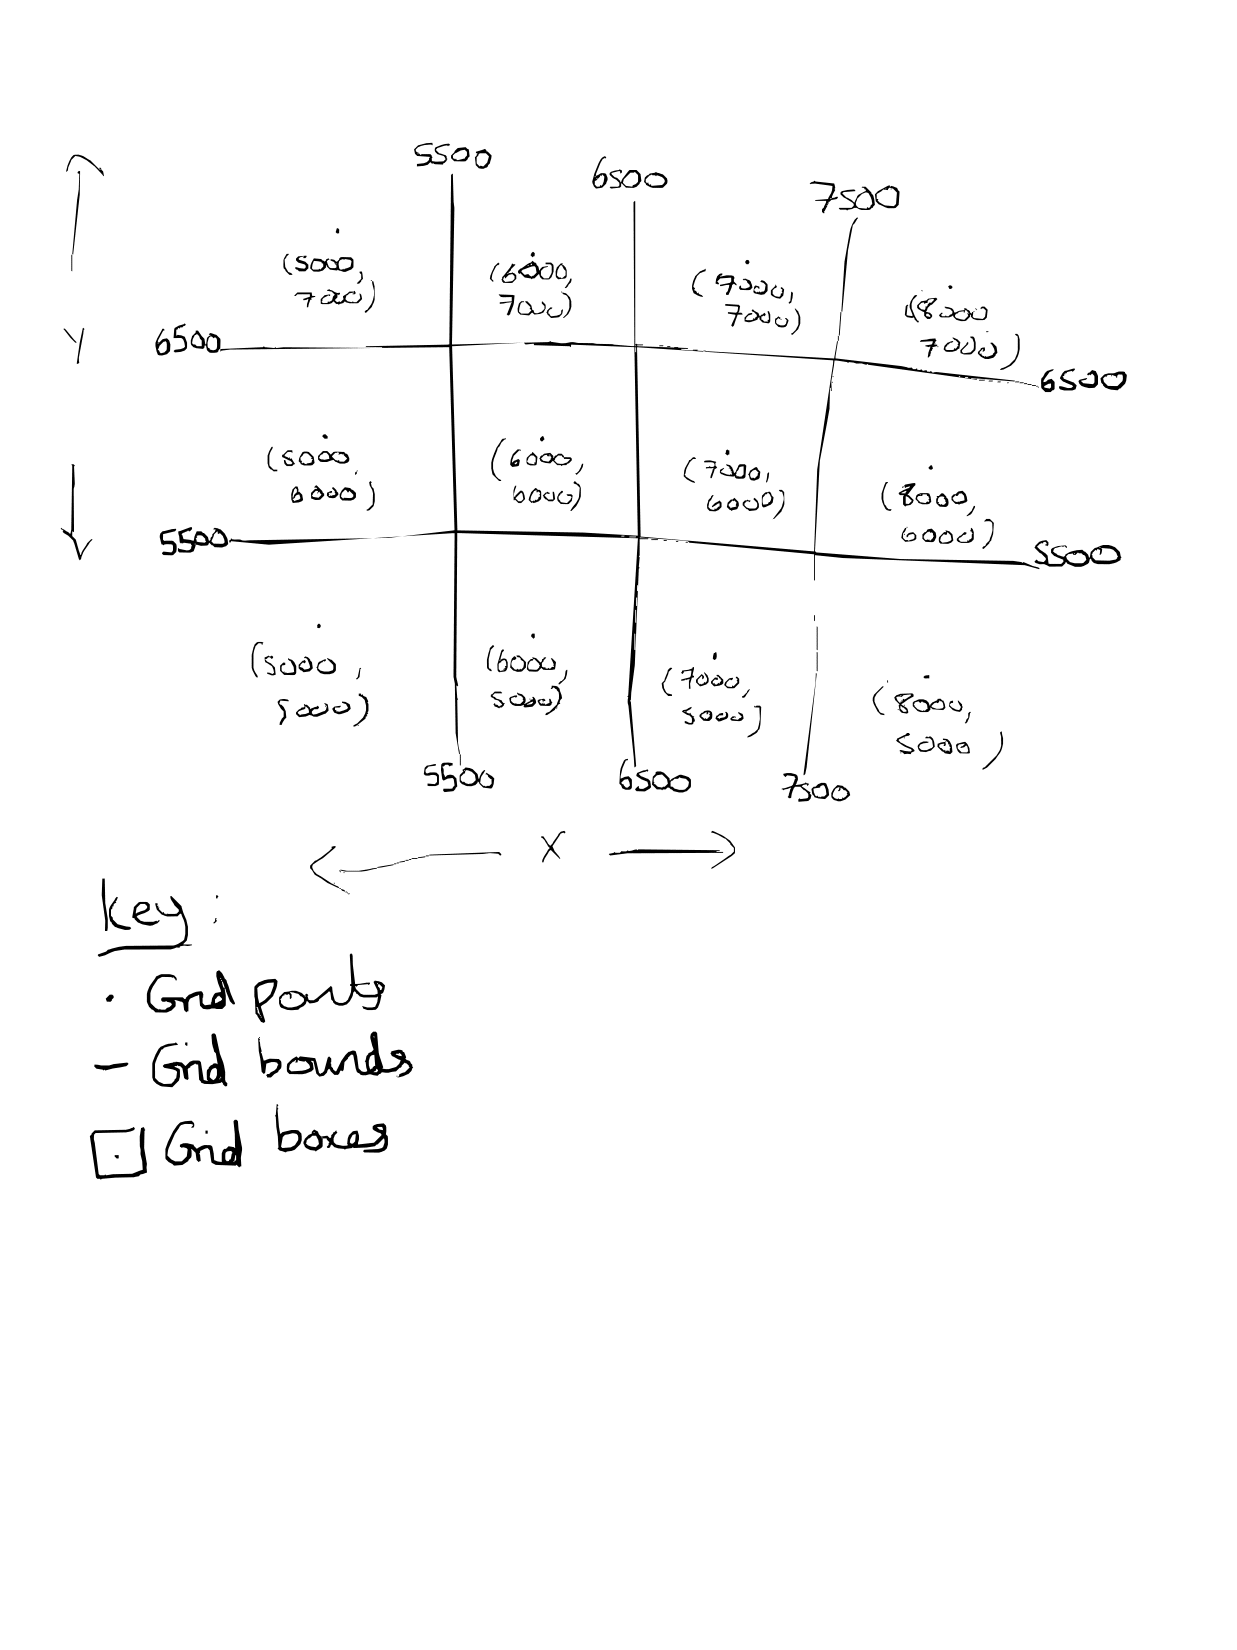

In [10]:
fig = Image(filename=('Scratch-1.png'))
fig

More information about the dataset is available by clicking on 'Attributes' to expand this section

All Zarr datasets that follow the CF-Conventions (a format standard for NetCDF, and Zarr by extension, originally created for climate-model data but slowly being expanded out to cover more disciplines in the geosciences) should look similar to this one. 

Variables are selected using ```datasetname['variablename']``` syntax

The ```.data``` attribute pulls out the underlying data array of the specified variable, which in the case of Zarr will be a Dask array. Dask arrays, as opposed to standard numpy arrays you might be used to working with, are 'chunked' into little parcels of data. It's a feature of the format that makes it most suitable for storage on the cloud. 

In [11]:
ds['rainfall_amount'].data

dask.array<open_dataset-rainfall_amount, shape=(236688, 1251, 701), dtype=float64, chunksize=(8760, 100, 100), chunktype=numpy.ndarray>

### Computations and visualisations with Xarray and Dask

#### An introduction to Lazy Loading

Before we go any further it is very important to know that Xarray loads data *lazily*. This means that the actual data is never loaded or computed until it absolutely has to be. So you may run some code that computes the mean of the dataset (e.g. ```dmean = ds['variable'].mean(dim='time')```), but the computation will only actually be carried out when you want to *see* the result of this calculation, e.g. through a plot or print statement, or saving to disk.

Dask also takes this a step further. Dask is a library designed to automatically parallelise computations; parallelisation is essential when dealing with chunked data such as Zarr on the cloud. Dask sits in the background working out how best to parallelise your computations, then whenever Xarray actually triggers a compute, Dask will automatically kick in and process the computation in parallel. However, with Dask, the *output* of the computation will not be saved, even if you save the output to a variable (e.g. ```dmean = ds['variable'].mean(dim='time')```). If you run the code again, Dask will *recompute* everything from scratch, the actual data is not stored in the variable ```dmean```, rather the Dask-instructions for computing it. This can make code very slow if not handled correctly. The best way to handle this is to make use of Dask's ```.persist()```and ```.compute()``` methods. Appending this on to the end of a calculation, such as ```dmean = ds['variable'].mean(dim='time').compute()``` will keep the data in memory.

The main difference between ```persist``` and ```compute``` is that ```persist``` will allow you to continue coding whilst dask computes the result in the background, whereas ```compute``` will wait until the computation is complete before letting you continue coding. I tend to find ```compute``` behaves the most intuitively.

Now with that out the way let's get to actually looking at the data!

#### Plot an individual time step

You can index the array and pull out a single timestep like you can any standard array-like object in Python

Xarray also adds a ```plot()``` method you can call to produce a rough-and-ready quick plot of the data you've selected, in this case the 37th timestep of the dataset

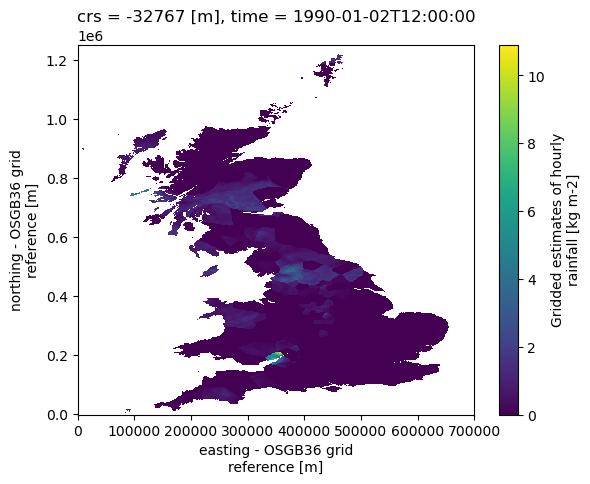

In [12]:
ds['rainfall_amount'][36,:,:].plot()

#### Customising plots

These plots can be customised to look nicer too. Note that we're making use of Dask's ```compute()``` method to save the variable ```plotpoint``` in memory, so that we don't have to rerun the processing needed to extract this point from the cloud whenever we rerun the plotting commands:

In [48]:
plotpoint = ds['rainfall_amount'][36,:,:].compute()

Text(0.5, 1.0, 'Rainfall $2^{nd}$ Jan 1990 12:00')

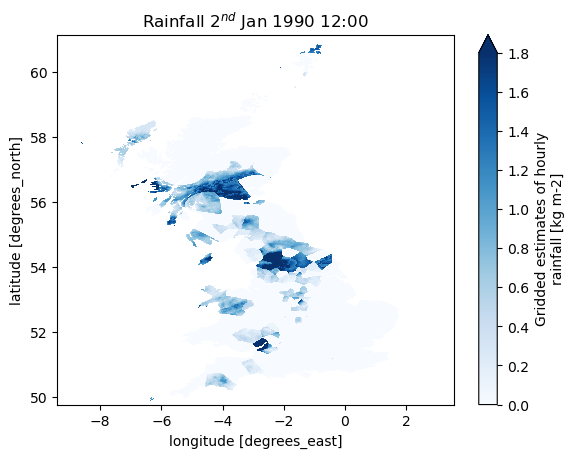

In [52]:
plotpoint.plot.pcolormesh('lon', 'lat', cmap='Blues', robust=True)
plt.title(r'Rainfall $2^{nd}$ Jan 1990 12:00')

Here we have:
- changed the axes to use lon/lat instead of x/y coordinates by specifying the dataset name of the longitude and latitude variables in the plotting command
- changed the colourmap to a nicer one (all pre-built colourmaps can be found at https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- changed the title to better describe the data
- used Xarray's 'robust' option, which modifies the colourbar to not stretch to the maximum of the data if it is an outlier. This stops a small area of very high values dominating the colourbar and making other variation invisible

But it would also be nice to have some coastlines. For this we have to go beyond what Xarray's built-in plotting can acheive and use the Cartopy package:

In [164]:
import cartopy.crs as ccrs # the set of map projections cartopy supports
import cartopy as cp # the full cartopy package

Passing the ```projection``` 'key-word argument' to the plotting function tells the plotting library to invoke cartopy to draw the plot using a given map projection. Here we are using the 'OSGB' map projection (a cartesian grid, in other words a flat plane approximation that ignores the curvature of the earth) which a lot of UK hydrological data will be on. For any data that is on a 'lon/lat' grid instead of an 'x/y' grid, the ```ccrs.PlateCarree()``` projection needs to be used. 

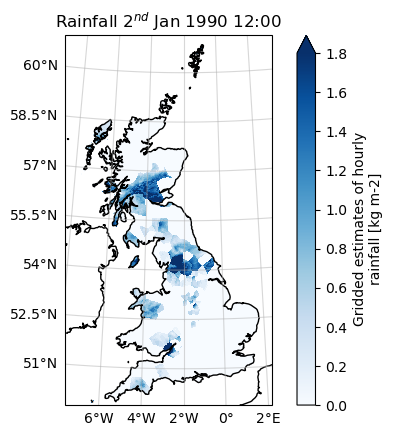

In [165]:
plot1 = plotpoint.plot.pcolormesh(cmap='Blues', robust=True, subplot_kws=dict(projection=ccrs.OSGB()))
plt.title(r'Rainfall $2^{nd}$ Jan 1990 12:00')
plot1.axes.coastlines() # add coastlines
gl = plot1.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1. 
gl.top_labels = False
gl.right_labels = False # remove the top and right gridlines labels to make the plot look nicer

#### Animations

It might also be nice to see how the data evolves over time in a video or GIF. This is a little more complicated to achieve, so I've broken it down into steps:

First extract out the data that you want in the animation, making sure to call ```.compute()``` so that the actual data is stored in memory, otherwise every drawing of a frame of the animation will re-download the data from the cloud which takes time and unnecessary bandwith. 

Note however that we don't have to do this with the time coordinates as they *are* actually loaded in to memory when we first read in the data. You can see this if you take a look at the dataset (by just running ```ds```) - all the variables are dask arrays *except* for ```t```, ```x``` and ```y``` (the coordinate variables) for which you can see the start and end of their actual values. 

In [168]:
data = ds['rainfall_amount'].sel(time=slice('2014-02-01', '2014-02-07')).compute()
timecoords = data.time.dt.strftime('%Y-%m-%d %H:%M').values # extract out string representations of the time coordinates

Set some key variables used in the plotting and animating:

In [169]:
xname = 'x' # name of the x dimension
yname = 'y' # name of the y dimension
timname = 't' # name of the t dimension
starttime = timecoords[0] # start datetime of the animation (e.g the first time in the data)
outname='./example_animation' # where to put the file + the first part of the output filename
title='Hourly Rainfall' # title to put on plot
colmap='Blues' # colour map to use, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin=0 # lower colourmap boundary of all plots (the colourbar needs to be the same across all plots)
vmax=data.quantile(0.98).compute() # upper colourmap boundary of all plots, using the 98th percentile of the data here
ext='mp4' # gif or mp4 (latter is recommended)

Before animating, we set up the first frame to check it all looks ok. Note that the animation is done by the matplotlib plotting library directly, so we plot the data using matplotlib directly instead of Xarray's built-in plot function. The commands are ultimately very similar, as the Xarray version is just a wrapper around matplotlib's version

Text(0, 0.5, 'rainfall_amount  kg m-2')

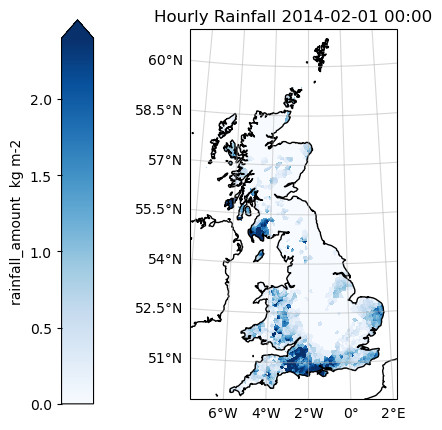

In [170]:
# create the directory to store the animation in if it doesn't exist
dirname = os.path.split(outname)[0]
if not os.path.exists(dirname):
    os.mkdir(dirname)

# extract out x and y coordinates
xs = data[xname].values
ys = data[yname].values

############################# CREATE THE FIRST FRAME ###########################
#
# set up the plot with coastlines
fig = plt.figure()
ax1 = plt.axes(projection = ccrs.OSGB())
ax1.coastlines()

# add in the x/y axis labels
gl = ax1.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# set the title
ax1.set_title(title + ' ' + starttime)

# plot the first frame using matplotlib directly
pcm = ax1.pcolormesh(xs, ys, data.sel(time=starttime).values, vmin=minval, vmax=maxval, cmap=colmap)
# manually create a colourbar to the left of the main plot
cbaxes=fig.add_axes([0.15, 0.1, 0.05, 0.8])
plt.colorbar(pcm, cax=cbaxes, extend='max') # extend the upper limit of the colourbar to make clear any values higher than it are the same colour
cbaxes.yaxis.set_label_position("left") # set the colourbar label position...
cbaxes.yaxis.tick_left() # ...and tickmarks
# set the ylabel of the colourbar to the xarray dataarray name and failing that, leave it blank
try:
    plotlab = data.name + '  ' + data.units
except AttributeError:
    plotlab = ''
cbaxes.set_ylabel(plotlab)

In [172]:
############################## CREATE THE ANIMATION FUNCTION #################################
#
# The animation function
# This defines what we want to happen everytime matplotlib plots a new frame
# It has to have one input, the frame number, and one output, the 'plot handle'
# (the object returned when you plot something)
def animate(f):
    print('Plotting frame ' + str(f+1)) # tell us what frame we're on
    ax1.clear() # clear the axes of the current plot
    ax1.coastlines(resolution='10m') #redraw the coastlines
    # redraw the axis labels
    gl = ax1.gridlines(draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    # re-set the title, noting that we are incrementing the date by one day each time
    ax1.set_title(title + ' ' + timecoords[f])
    # replot the data, noting that we are incrementing through the time axis,
    # plotting the next frame each time
    pcm = ax1.pcolormesh(xs, ys, data.isel(time=f).values, vmin=minval, vmax=maxval, cmap=colmap)
    return pcm,
##############################################################################################

# use the animation function to create the animation
# you need to provide the figure handle, animation function, 
# and frame numbers you want to plot. Setting 'blit=True' means that
# only the bits of the plot that actually change from frame to
# frame will be redrawn. This is much more efficient.
nframes = len(timecoords)
print('Total frames = ' + str(nframes))
anim = animation.FuncAnimation(fig, animate, range(0,len(timecoords)), blit=True)

# save the plot using ffmpeg to create an mp4, or convert to create a gif
# mp4 is much more efficient in terms of file size and memory
# fps = frames per second (speed)
# dpi = dots per inch (resolution)
# bitrate = video quality (less/more compression)
if ext=='mp4':
    anim.save(outname + '.mp4', fps=10, dpi=300, bitrate=10000, writer='ffmpeg')
elif ext=='gif':
    anim.save(outname + '.gif', writer='imagemagick', fps=10, dpi=300)
else:
    raise Error('format ' + ext + 'not supported')

print('Animation saved to ' + outname + '.' + ext)

Total frames = 168
Plotting frame 1
Plotting frame 1
Plotting frame 1
Plotting frame 1
Plotting frame 2
Plotting frame 3
Plotting frame 4
Plotting frame 5
Plotting frame 6
Plotting frame 7
Plotting frame 8
Plotting frame 9
Plotting frame 10
Plotting frame 11
Plotting frame 12
Plotting frame 13
Plotting frame 14
Plotting frame 15
Plotting frame 16
Plotting frame 17
Plotting frame 18
Plotting frame 19
Plotting frame 20
Plotting frame 21
Plotting frame 22
Plotting frame 23
Plotting frame 24
Plotting frame 25
Plotting frame 26
Plotting frame 27
Plotting frame 28
Plotting frame 29
Plotting frame 30
Plotting frame 31
Plotting frame 32
Plotting frame 33
Plotting frame 34
Plotting frame 35
Plotting frame 36
Plotting frame 37
Plotting frame 38
Plotting frame 39
Plotting frame 40
Plotting frame 41
Plotting frame 42
Plotting frame 43
Plotting frame 44
Plotting frame 45
Plotting frame 46
Plotting frame 47
Plotting frame 48
Plotting frame 49
Plotting frame 50
Plotting frame 51
Plotting frame 52
Plo

In [178]:
from IPython.display import Video
Video("example_animation.mp4")

#### Climatology

We can also do things such as computing the monthly climatology. This takes ~an hour to compute using the in-built default dask setup (we do have access to a more powerful dask cluster on datalabs, but that might be a touch out of scope for this notebook?), so best to run it once and save it to disk so that it can be loaded in when we next want to access it, and isn't lost when we close the python kernel running the notebook. 

To that end, you only need to run the next cell if you haven't already generated the 'gear1hrly_climatology.nc' file.

In [ ]:
with ProgressBar():
    climo = ds['rainfall_amount'].groupby('time.month').mean()
    climo = dailyavg.compute()

climo.to_netcdf('gear1hrly_climatology.nc')

Otherwise you can just load it in like you would any netcdf dataset:

In [175]:
climo = xr.open_dataarray('gear1hrly_climatology.nc')

Let's take a look at the climatology data, all the nans you can see are just where this is no data in the sea. As it is only showing a preview of the start and the end of the data, sea is all there is!

In [176]:
climo

<xarray.DataArray 'rainfall_amount' (month: 12, y: 1251, x: 701)> Size: 84MB
[10523412 values with dtype=float64]
Coordinates:
    crs      int16 2B ...
    lat      (y, x) float64 7MB ...
    lon      (y, x) float64 7MB ...
  * x        (x) float64 6kB 0.0 1e+03 2e+03 3e+03 ... 6.98e+05 6.99e+05 7e+05
  * y        (y) float64 10kB 1.25e+06 1.249e+06 1.248e+06 ... 2e+03 1e+03 0.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    grid_mapping:   crs
    long_name:      Gridded estimates of hourly rainfall
    standard_name:  rainfall_amount
    units:          kg m-2
    valid_max:      500.0
    valid_min:      0.0

Once again we can easily produce a quick plot of the data, in this case the 2nd month of the climatology:

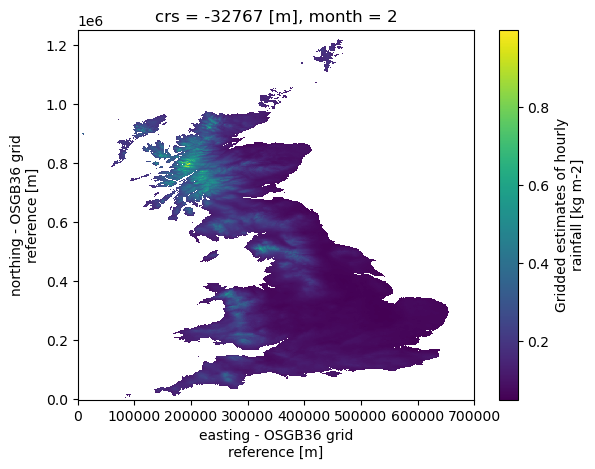

In [177]:
climo[1,:,:].plot()

Or a plot comparing two different months:

In [205]:
colmap='Blues' # colour map to use, see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
vmin=0 # lower colourmap boundary of all plots (the colourbar needs to be the same across all plots)
vmax=0.5 # upper colourmap boundary of all plots

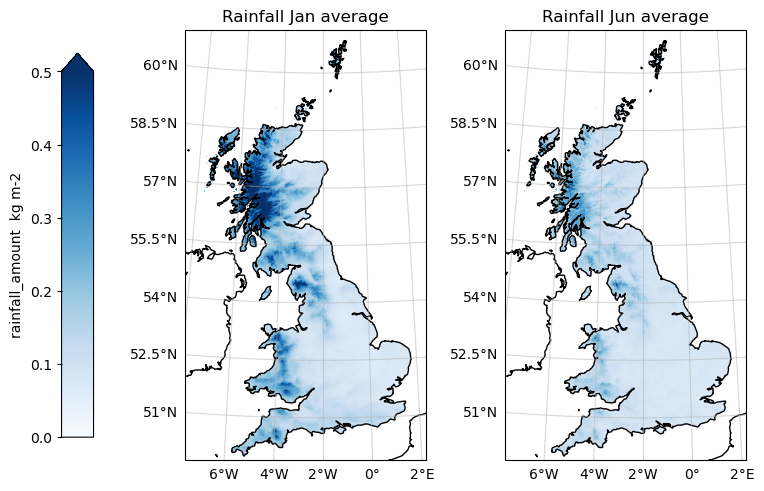

In [206]:
fig, axs = plt.subplots(ncols=2, constrained_layout=True, subplot_kw=dict(projection=ccrs.OSGB()))
ax1 = axs[0]
ax2 = axs[1]

plot1 = ax1.pcolormesh(xs, ys, climo[0,:,:].values, vmin=vmin, vmax=vmax, cmap=colmap)
plot2 = ax2.pcolormesh(xs, ys, climo[7,:,:].values, vmin=vmin, vmax=vmax, cmap=colmap)

# manually create a colourbar to the left of the main plot
cbaxes=fig.add_axes([-0.1, 0.1, 0.05, 0.8])
plt.colorbar(plot1, cax=cbaxes, extend='max') # extend the upper limit of the colourbar to make clear any values higher than it are the same colour
cbaxes.yaxis.set_label_position("left") # set the colourbar label position...
cbaxes.yaxis.tick_left() # ...and tickmarks
# set the ylabel of the colourbar to the xarray dataarray name and failing that, leave it blank
try:
    plotlab = dailyavg.name + '  ' + dailyavg.units
except AttributeError:
    plotlab = ''
cbaxes.set_ylabel(plotlab)

ax1.set_title('Rainfall Jan average')
ax2.set_title('Rainfall Jun average')
ax1.axes.coastlines() # add coastlines
ax2.axes.coastlines() # add coastlines
gl1 = plot1.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1. 
gl2 = plot2.axes.gridlines(draw_labels=True, alpha=0.5) # add gridlines. The alpha parameter is the transparency between 0 and 1. 
gl1.top_labels = False
gl1.right_labels = False
gl2.top_labels = False
gl2.right_labels = False # remove the top and right gridlines labels to make the plot look nicer

We can also select out a particular gridpoint to view the climatology there, the syntax is fairly intuitive:

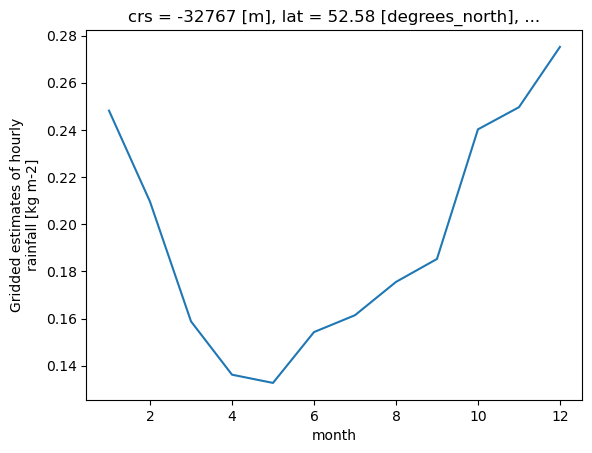

In [207]:
climo.sel(x=275000, y=300000).plot()

We could also compare this to a different gridpoint:

Text(0.5, 1.0, 'Climatology of two grid points')

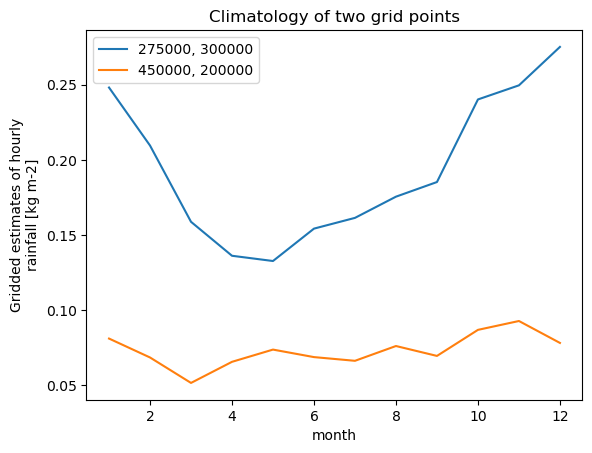

In [208]:
climopoint1 = climo.sel(x=275000, y=300000)
climopoint2 = climo.sel(x=450000, y=200000)

point1 = climopoint1.plot()
ax1 = plt.gca()
point2 = climopoint2.plot(ax=ax1)

point1[0].set_label('275000, 300000')
point2[0].set_label('450000, 200000')
plt.legend()
plt.title('Climatology of two grid points')

### Catchment Extraction